# Importing Libararies and Reading CSV File

In [176]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import tensorflow as tf
import os
# plotting
import seaborn as sn
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')
import re
import spacy
import string
import pickle


import keras
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional, GlobalMaxPool1D, BatchNormalization
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

In [177]:
!gdown --id 1tsPhOCVcDtsR4pSHB-pI-wRze9oEBmXR

Downloading...
From: https://drive.google.com/uc?id=1tsPhOCVcDtsR4pSHB-pI-wRze9oEBmXR
To: /content/sentiment_final.csv
100% 1.40M/1.40M [00:00<00:00, 6.54MB/s]


In [178]:
import io
dataset = pd.read_csv('sentiment_final.csv')

# Data Exploratory

In [179]:
dataset.head()

,text,sentiment
0,RT @ScottWalker: Didn't catch the full #GOPdeb...,Positive
1,RT @RobGeorge: That Carly Fiorina is trending ...,Positive
2,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,Positive
3,"RT @GregAbbott_TX: @TedCruz: ""On my first day ...",Positive
4,RT @warriorwoman91: I liked her and was happy ...,Negative


In [180]:
dataset['sentiment'].unique()

array(['Positive', 'Negative'], dtype=object)

In [181]:
from sklearn.preprocessing import OrdinalEncoder
ord_enc = OrdinalEncoder()
dataset['sentiment'] = ord_enc.fit_transform(dataset[['sentiment']])
# Positive:1
# Negative:0

In [182]:
# get common words in training dataset
from collections import Counter
all_words = []
for line in list(dataset['text']):
    words = line.split()
    for word in words:
      if(len(word)>2):
        all_words.append(word.lower())
    
    
Counter(all_words).most_common(10)

[('the', 6823),
 ('#gopdebate', 6296),
 ('#gopdebates', 4114),
 ('and', 2247),
 ('@rwsurfergirl:', 1805),
 ('you', 1486),
 ('for', 1456),
 ('that', 1175),
 ('fox', 1170),
 ('trump', 1078)]

In [183]:
Counter(all_words).most_common()[-20:]

[('wisconsin.', 1),
 ('pivot', 1),
 ('whims', 1),
 ('parents!!!!!!!', 1),
 ('moe', 1),
 ('stooge', 1),
 ('https://t.co/ucd675mrmy', 1),
 ('@swincash:', 1),
 ('this....hmmm', 1),
 ('http://t.co/2ucyupludo', 1),
 ('@jessicavalenti', 1),
 ('coif', 1),
 ('ear-to-head', 1),
 ('ratio', 1),
 ('@the818:', 1),
 ('distance', 1),
 ('#notme', 1),
 ('@georgehenryw:', 1),
 ('exceeded', 1),
 ('@laura4fairtax', 1)]

In [184]:
freq = set(w for (w,wc) in Counter(all_words).most_common(20))
rare = set(w for (w,wc) in Counter(all_words).most_common()[-20:])

# Processing Text Data

In [185]:
# nltk
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
!pip install emot

In [186]:
nltk.download('stopwords')
stopword = set(stopwords.words('english'))
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

The Preprocessing steps taken are:

1. Lower Casing: Each text is converted to lowercase.
2. Removing URLs: Links starting with "http" or "https" or "www" are replaced by "".
3. Removing Usernames: Replace @Usernames with word "". (eg: "@XYZ" to "")
4. Removing Hashtags: Replace #... with "".
5. Removing Punctuations
6. Converting Emojis and Emoticons to Words
7. Removing Short Words: Words with length less than 2 are removed.

 Removing Stopwords: Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. (eg: "the", "he", "have")
8. Lemmatizing: Lemmatization is the process of converting a word to its base form. (e.g: “wolves” to “wolf”)

In [202]:
urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
userPattern = '@[^\s]+'
hashtagPattern = '#[^\s]+'
emojipunc = '_'
def process_tweets(tweet):
    # 1. Lower Casing
    tweet = tweet.lower()
    tweet=tweet[1:]
    # 2. Removing all URls 
    tweet = re.sub(urlPattern,'',tweet)
    # 3. Removing all @username.
    tweet = re.sub(userPattern,'', tweet) 
    # # 4. Removing all Hashtags #.
    # tweet = re.sub(hashtagPattern,'', tweet) 
    # 5. Remove punctuations
    tweet = re.sub('-',' ', tweet)
    tweet = tweet.translate(str.maketrans("","",string.punctuation))



    # 6. Converting emojis and emoticons to Words
    from emot.emo_unicode import UNICODE_EMO, EMOTICONS
    # Converting emojis to words
    for emot in UNICODE_EMO:
      tweet = tweet.replace(emot, "_".join(UNICODE_EMO[emot].replace(",","").split(' ')))
    # Converting emoticons to words    
    for emot in EMOTICONS:
      tweet = re.sub(u'('+emot+')', "_".join(EMOTICONS[emot].replace(",","").split(' ')), tweet)
    tweet = re.sub(emojipunc,' ',tweet)
    # Removing Numbers
    tweet = tweet.replace("[0-9]", " ")

    #tokenizing words
    tokens = word_tokenize(tweet)
    # 7. Removing Stop Words and words with length less than 2
    final_tokens = [w for w in tokens if (w not in stopword)]
    # 8. Reducing a word to its word stem 
    wordLemm = WordNetLemmatizer()
    finalwords=[]
    for w in final_tokens:
      if len(w)>1:
        word = wordLemm.lemmatize(w)
        finalwords.append(word)

    final_tokens = [w for w in finalwords if (w not in freq)]
    # 8. Removing freq and rare 
    finalwords=[]
    for w in final_tokens:
      finalwords.append(w)
    return ' '.join(finalwords)

In [203]:
nlp = spacy.load('en', disable=['parser', 'ner'])

# function to lemmatize text
def lemmatization(texts):
    output = []
    for i in texts:
        s = [token.lemma_ for token in nlp(i)]
        output.append(' '.join(s))
    return output

In [204]:
dataset['processed_tweets'] = dataset['text'].apply(lambda x: process_tweets(x))
dataset['processed_tweets'] = lemmatization(dataset['processed_tweets'])
print('Text Preprocessing complete.')

Text Preprocessing complete.


In [205]:
dataset.head(10)

,text,sentiment,processed_tweets
0,RT @ScottWalker: Didn't catch the full #GOPdeb...,1.0,do not catch full last night scott good line 9...
1,RT @RobGeorge: That Carly Fiorina is trending ...,1.0,carly fiorina trend hour debate man complete s...
2,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,1.0,deliver high rating history presidential debate
3,"RT @GregAbbott_TX: @TedCruz: ""On my first day ...",1.0,first day rescind every illegal executive acti...
4,RT @warriorwoman91: I liked her and was happy ...,0.0,like happy hear go moderator anymore
5,Deer in the headlights RT @lizzwinstead: Ben C...,0.0,eer headlight rt ben carson may brain surgeon ...
6,RT @NancyOsborne180: Last night's debate prove...,0.0,last night debate prove
7,@JGreenDC @realDonaldTrump In all fairness #Bi...,0.0,jgreendc fairness own phrase
8,RT @WayneDupreeShow: Just woke up to tweet thi...,1.0,wake tweet good line night via
9,Me reading my family's comments about how grea...,0.0,read family comment great


### bert

In [206]:
!pip install transformers &> /dev/null
!pip install -U bert-serving-server bert-serving-client &> /dev/null
import transformers as ppb
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)
tokenized = dataset.processed_tweets.apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

tweets = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Tokenizing and Pad

In [207]:
# from keras import regularizers
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# vocab_size = 2000
# max_length = 250
# trunc_type='post'
# padding_type='pre'
# oov_tok = "<OOV>"

# tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
# tokenizer.fit_on_texts(dataset.processed_tweets)
# sequences = tokenizer.texts_to_sequences(dataset.processed_tweets)
# tweets = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [208]:
X_train, X_test, y_train, y_test = train_test_split(tweets, dataset.sentiment, test_size=0.2, random_state=None)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=None)

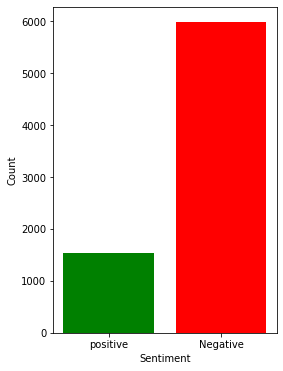

Count of Positives = 1530 & Count of Negatives = 5980


In [209]:
positive = len(y_train[y_train == 1])
negative = len(y_train[y_train == 0])
plt.figure(figsize=(4,6))
plt.bar(['positive', 'Negative'],[positive,negative],color=['g','r'])
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()
print("Count of Positives = %i & Count of Negatives = %i" %(positive, negative))

# SMOTE: Over Sampling

In [210]:
!pip install imbalanced-learn &> /dev/null
import imblearn
from imblearn.over_sampling import SMOTE
oversample = SMOTE(random_state=None, k_neighbors=2)
X_train, y_train = oversample.fit_resample(X_train, y_train)

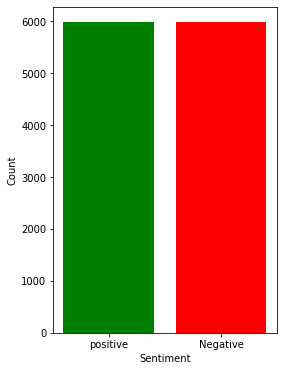

Count of Positives = 5980 & Count of Negatives = 5980


In [211]:
positive = len(y_train[y_train == 1])
negative = len(y_train[y_train == 0])
plt.figure(figsize=(4,6))
plt.bar(['positive', 'Negative'],[positive,negative],color=['g','r'])
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()
print("Count of Positives = %i & Count of Negatives = %i" %(positive, negative))

# Model

In [212]:
from keras.models import Sequential
from keras import layers
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
def lstm():
  model = Sequential()
  # model.add(layers.Embedding(vocab_size, 128))
  model.add(layers.Embedding(30000, 150))
  model.add(Bidirectional(LSTM(100, return_sequences = True, activation="tanh", recurrent_activation="sigmoid", use_bias=True, recurrent_dropout=0.0
                               , unroll=False)))
  model.add(Bidirectional(LSTM(80, return_sequences = True, activation="tanh", recurrent_activation="sigmoid", use_bias=True, recurrent_dropout=0.0
                               , unroll=False)))
  model.add(GlobalMaxPool1D())

  model.add(BatchNormalization())
  model.add(Dropout(0.2))
  model.add(Dense(32, activation = "relu"))
  model.add(Dropout(0.2))
  model.add(Dense(16, activation = "relu"))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation = 'sigmoid'))


  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model
model = lstm()

checkpoint = ModelCheckpoint('model.h5', monitor = 'val_loss', verbose = 1, save_best_only = True)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, verbose = 1, patience = 3, min_lr = 0)
history = model.fit(X_train, y_train, epochs = 20,batch_size = 64,validation_data = (X_val, y_val),callbacks = [reduce_lr, checkpoint])

Epoch 1/20
187/187 [==============================] - 22s 85ms/step - loss: 0.5234 - accuracy: 0.7280 - val_loss: 0.5086 - val_accuracy: 0.8332

Epoch 00001: val_loss improved from inf to 0.50863, saving model to model.h5
Epoch 2/20
187/187 [==============================] - 14s 75ms/step - loss: 0.2334 - accuracy: 0.9120 - val_loss: 0.4189 - val_accuracy: 0.7968

Epoch 00002: val_loss improved from 0.50863 to 0.41895, saving model to model.h5
Epoch 3/20
187/187 [==============================] - 14s 74ms/step - loss: 0.1674 - accuracy: 0.9365 - val_loss: 0.6201 - val_accuracy: 0.8248

Epoch 00003: val_loss did not improve from 0.41895
Epoch 4/20
187/187 [==============================] - 14s 74ms/step - loss: 0.1389 - accuracy: 0.9479 - val_loss: 0.6457 - val_accuracy: 0.8378

Epoch 00004: val_loss did not improve from 0.41895
Epoch 5/20
187/187 [==============================] - 14s 73ms/step - loss: 0.1269 - accuracy: 0.9505 - val_loss: 2.5862 - val_accuracy: 0.5741

Epoch 00005: Re

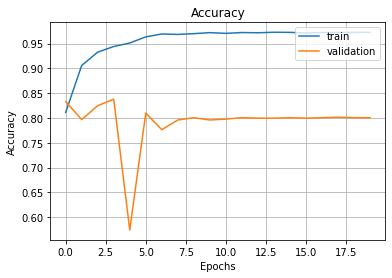

In [213]:
fig = plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'validation'], loc='upper right')
plt.grid()
plt.show()

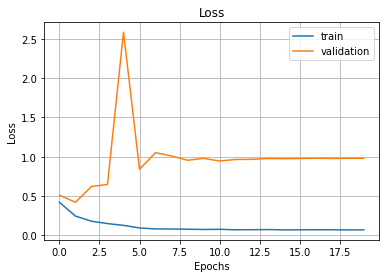

In [214]:
fig = plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'validation'], loc='upper right')
plt.grid()
plt.show()

## Testing

In [215]:
y_pred = model.predict(X_test)
for i in range(len(y_pred)):
  if y_pred[i] > 0.5:
    y_pred[i] = 1
  else:
    y_pred[i] = 0

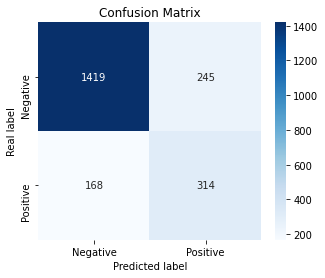

              precision    recall  f1-score   support

         0.0       0.89      0.85      0.87      1664
         1.0       0.56      0.65      0.60       482

    accuracy                           0.81      2146
   macro avg       0.73      0.75      0.74      2146
weighted avg       0.82      0.81      0.81      2146



In [217]:
from sklearn.metrics import confusion_matrix , classification_report
class_names=['Negative', 'Positive']
confusion_mtx = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sn.heatmap(confusion_mtx, annot=True,cmap="Blues", fmt='d',xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('Real label')
plt.show()
print(classification_report(y_test,y_pred))